In [1]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
# Augment the data
transform = transforms.Compose([
    transforms.RandomRotation(90),
    transforms.RandomAffine(0, (0.1, 0.1)),
    transforms.ToTensor()
])

In [3]:
# Load in the dataset
train_dataset = MNIST(
    root="../Lectures",
    train=True,
    transform=transform,
    download=False
)

In [ ]:
test_dataset = MNIST(
    root="../Lectures",
    train=False,
    transform=transforms.ToTensor(),
    download=False
)

In [5]:
# DataLoader for train and test sets
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [14]:
# Create a RNN model with GRU
class GRU_RNN(nn.Module):
    def __init__(self, num_inputs, num_outs, num_hiddens, num_layers):
        super(GRU_RNN, self).__init__()
        
        self.L = num_layers
        self.D = num_inputs
        self.M = num_hiddens
        self.K = num_outs
        
        # RNN layer
        self.rnn = nn.GRU(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True
        )
        
        # Dense layer
        self.dense = nn.Linear(self.M, self.K)
    
    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M)
        out, _ = self.rnn(X, h0)
        out = self.dense(out[:, -1, :])
        return out

In [20]:
# Initiate the model
model = GRU_RNN(28, 10, 32, 4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [12]:
num_epochs = 20

In [ ]:
# Train the model
loss_history = np.zeros(num_epochs)
test_history = np.zeros(num_epochs)
for epoch in range(num_epochs):
    # train
    train_loss = []
    for inputs, targets in train_loader:
        # Reshape to ignore the color channel
        inputs = inputs.view(inputs.size(0), inputs.size(2), inputs.size(3))
        optimizer.zero_grad()
        
        y_hat_train = model(inputs)
        loss = criterion(y_hat_train, targets)
        train_loss.append(loss.item())
        
        loss.backward()
        optimizer.step()
    
    # average train loss
    loss_history[epoch] = np.mean(train_loss)
    
    # test
    test_loss = []
    for inputs, targets in test_loader:
        inputs = inputs.view(inputs.size(0), inputs.size(2), inputs.size(3))
        y_hat_test = model(inputs)
        tloss = criterion(y_hat_test, targets)
        test_loss.append(tloss.item())
    
    test_history[epoch] = np.mean(test_loss)

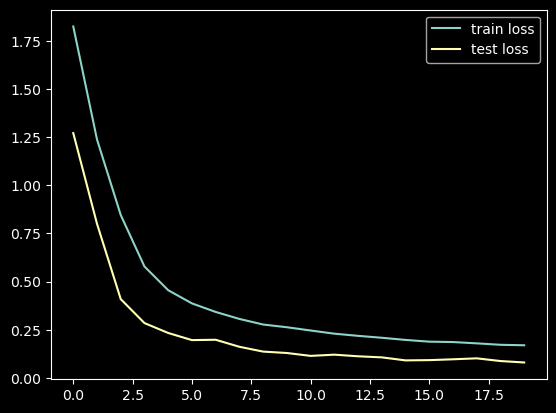

In [22]:
plt.plot(loss_history, label="train loss")
plt.plot(test_history, label="test loss")
plt.legend()
plt.show()

In [39]:
# Train and test accuracy
def compute_accuracy(model, data_loader):
    n_correct, n_total = 0, 0
    for inputs, targets in data_loader:
        inputs = inputs.view(inputs.size(0), inputs.size(2), inputs.size(3))
        y_hat = model(inputs)

        _, preds = torch.max(y_hat, axis=1)
        n_total += y_hat.size(0)
        n_correct += (preds == targets).sum().item()
    
    return n_correct/n_total

In [40]:
train_acc = compute_accuracy(model, train_loader)
test_acc = compute_accuracy(model, test_loader)
train_acc, test_acc

(0.9494166666666667, 0.9751)

In [41]:
import sys, os
sys.path.append(os.path.abspath("../utils"))

from confusion_matrix_plot import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

Confusion matrix with no normalization
[[ 961    0    0    2    0    3    9    1    1    3]
 [   0 1126    2    3    0    1    0    2    1    0]
 [   1    3 1001    8    5    0    0   12    1    1]
 [   0    1    2  998    0    4    0    3    1    1]
 [   0    0    1    2  950    0    0    5    3   21]
 [   0    1    0    6    2  866    9    1    1    6]
 [   2    5    0    0    5    8  938    0    0    0]
 [   0    7   20    2    5    1    0  984    0    9]
 [   0    0    6    6    5    4    4    1  938   10]
 [   0    1    0    0   10    5    0    4    0  989]]


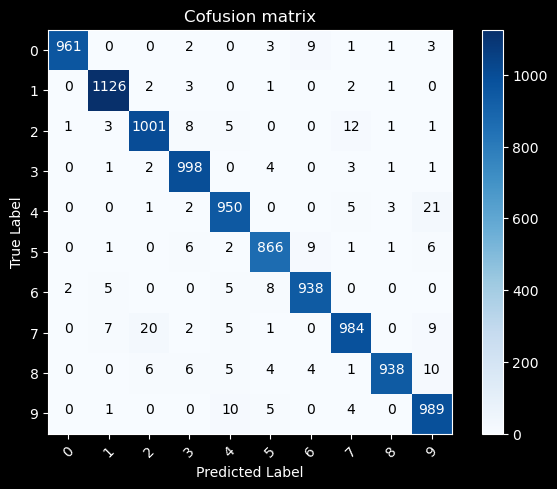

In [42]:
p_test = np.array([])
y_test = test_dataset.targets.numpy()

for inputs, targets in test_loader:
    inputs = inputs.view(inputs.size(0), inputs.size(2), inputs.size(3))
    y_hat = model(inputs).detach()
    _, preds = torch.max(y_hat, axis=1)
    p_test = np.concatenate((p_test, preds.numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, range(0, 10))